<a href="https://colab.research.google.com/github/WolfPitToad/Stringstein/blob/main/Sringstein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Modules
import matplotlib.pyplot as plt
import requests
import nltk
import re
from bs4 import BeautifulSoup
import numpy as np
import random
import tensorflow as tf
import os

In [ ]:
from traitlets.utils import text
url= 'https://www.gutenberg.org/cache/epub/42324/pg42324.txt' #Url
book=requests.get(url) 
soup=BeautifulSoup(book.text,'html.parser')
text=soup.get_text() #Generate the text
print ('"'+text[439289:439322]+'"') #A phrase excracted from the book
words=re.findall('\w+',text)#list with all the words inside the text

"Evil
thenceforth became my good."


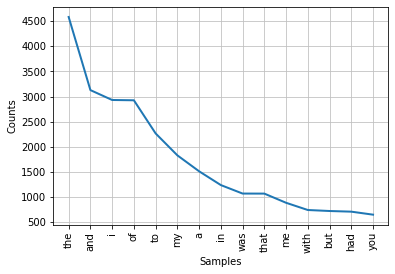

In [ ]:
#Eliminate Upper chracters from the data
w_list=[]
for word in words:
  w_list.append(word.lower()) #Add another element in the list
text_l=nltk.Text(w_list) 
#Get all the words frequency
frqdis=nltk.FreqDist(w_list)
#Generate unique vector of words in alphabetical order instead of frequency
values, counts = np.unique(text_l, return_counts=True)
frqdis.plot(15)

In [ ]:
#Get a random word from the list and its number of appearences }
example_w = []
for a in range (3):
  rd_nums=np.random.randint(1,len(counts))
  print ('Word "'+ values[rd_nums]+ '", times found:')
  print(counts[rd_nums])
  example_w.append(values[rd_nums])

Word "forehead", times found:
2
Word "surrounded", times found:
18
Word "disliked", times found:
1


In [ ]:
#Get unique characters
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

92 unique characters


In [ ]:
print(vocab)

['\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'æ', 'è', 'é', 'ê', 'ô', '\ufeff']


In [ ]:
#Generate new vocabulary
import string
vocab = string.ascii_letters + " .,;'1234567890"+'\r'+'\n'
print(vocab)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'1234567890



In [ ]:
#Encode chracters
chars = tf.strings.unicode_split(example_w, input_encoding='UTF-8')
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
ids = ids_from_chars(chars)
print(ids)

<tf.RaggedTensor [[6, 15, 18, 5, 8, 5, 1, 4], [19, 21, 18, 18, 15, 21, 14, 4, 5, 4],
 [4, 9, 19, 12, 9, 11, 5, 4]]>


In [ ]:
#Decoding characters
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
chars_id = chars_from_ids(ids)
tf.strings.reduce_join(chars_id, axis=-1).numpy()

array([b'forehead', b'surrounded', b'disliked'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(465593,), dtype=int64, numpy=array([ 0, 46,  8, ..., 54, 68, 69])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
#Iter characters 
for ids in ids_dataset.take(23):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

[UNK]
T
h
e
 
P
r
o
j
e
c
t
 
G
u
t
e
n
b
e
r
g
 


In [ ]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
for seq in sequences.take(1):
  print(text_from_ids(seq).numpy())

b'[UNK]The Project Gutenberg EBook of Frankenstein, by Mary W. Shelley\r\n\r\nThis eBook is for the use of anyo'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Frankenstein"))

(['F', 'r', 'a', 'n', 'k', 'e', 'n', 's', 't', 'e', 'i'],
 ['r', 'a', 'n', 'k', 'e', 'n', 's', 't', 'e', 'i', 'n'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'[UNK]The Project Gutenberg EBook of Frankenstein, by Mary W. Shelley\r\n\r\nThis eBook is for the use of any'
Target: b'The Project Gutenberg EBook of Frankenstein, by Mary W. Shelley\r\n\r\nThis eBook is for the use of anyo'


In [ ]:
# Batch size
BATCH_SIZE = 256
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(256, 100), dtype=tf.int64, name=None), TensorSpec(shape=(256, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

# Modelo extraido de: https://www.tensorflow.org/text/tutorials/text_generation

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel( vocab_size=len(ids_from_chars.get_vocabulary()), embedding_dim=embedding_dim, rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(256, 100, 70) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  17920     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  71750     
                                                                 
Total params: 4,027,974
Trainable params: 4,027,974
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([16, 18,  0, 14, 14, 22, 14, 61, 35, 52,  1, 14, 49, 49, 52, 45, 38,
       59, 49,  4, 27, 34, 53,  9, 12, 46, 28,  5, 16,  0, 33, 69, 38, 23,
        3, 38, 29, 11, 29, 52, 46, 50, 14,  5, 57, 11,  0, 37, 43, 22,  1,
       16, 24, 63, 37,  5, 59, 65, 24, 22, 41,  8,  3, 67, 11, 29, 52, 46,
       34, 34, 10, 54, 20, 45, 18, 45, 22, 66, 34, 17, 42, 57,  8, 46, 58,
       26, 45, 14, 11, 19, 58, 66, 14, 28, 40, 18, 11, 57, 49, 26])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'm my own friends, and be my own protector. My life had hitherto\r\nbeen remarkably secluded and domest'

Next Char Predictions:
 b"pr[UNK]nnvn4IZanWWZSL2WdAH ilTBep[UNK]G\nLwcLCkCZTXne'k[UNK]KQvapx6Ke28xvOhc0kCZTHHj.tSrSv9HqP'hT1zSnks19nBNrk'Wz"


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (256, 100, 70)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.250032, shape=(), dtype=float32)


In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './t_chkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
#" Entrenado 8 veces con 20 epocas total 12 min", a partir de la 3/6 epoca ya jala chido
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback],verbose=1)
model.save(checkpoint_dir)

Epoch 1/20
18/18 [==============================] - 7s 361ms/step - loss: 0.0624
Epoch 2/20
18/18 [==============================] - 5s 299ms/step - loss: 0.0625
Epoch 3/20
18/18 [==============================] - 4s 226ms/step - loss: 0.0625
Epoch 4/20
18/18 [==============================] - 5s 248ms/step - loss: 0.0628
Epoch 5/20
18/18 [==============================] - 5s 264ms/step - loss: 0.0624
Epoch 6/20
18/18 [==============================] - 5s 225ms/step - loss: 0.0623
Epoch 7/20
18/18 [==============================] - 6s 336ms/step - loss: 0.0623
Epoch 8/20
18/18 [==============================] - 5s 282ms/step - loss: 0.0623
Epoch 9/20
18/18 [==============================] - 7s 350ms/step - loss: 0.0623
Epoch 10/20
18/18 [==============================] - 6s 326ms/step - loss: 0.0623
Epoch 11/20
18/18 [==============================] - 5s 242ms/step - loss: 0.0626
Epoch 12/20
18/18 [==============================] - 6s 347ms/step - loss: 0.0632
Epoch 13/20
18/18 [======

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
import time
start = time.time()
states = None
next_char = tf.constant(['death'])
result = [next_char]

for n in range(200):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

death. I dare not ask you to do what I think right, for I
may still be misled by passion.

These murd a wretch as were gratified and reflection, I
concluded that the justice due both to him and my fell 

________________________________________________________________________________

Run time: 0.4778919219970703


In [ ]:
interesting_results=[]
def save_results(result):
  interesting_results.append(result)

In [ ]:
save_results(result)

In [ ]:
print(result)

tf.Tensor([b'before me. I gasped for breath;\r\nand, throwing myself on the body, I excleained in the hemands, of which I\r\nshall jud the misery which he should real tho our smilis departed.\r\n\r\nAnd you will think of th'], shape=(1,), dtype=string)


In [ ]:
import time
start = time.time()
states = None
next_char = tf.constant(['unio'])
result = [next_char]

for n in range(300):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

union with me a sickening
sinks into a long time braught; with you on your wedding nights. I passed through
means cousin; I believe that it were better for you if you
were dead, for I fancy when they were nearly extinction, that I should I bend my steps towards the trees.

1.E.  If is impossible to 

________________________________________________________________________________

Run time: 0.7463767528533936


In [ ]:
import time
start = time.time()
states = None
next_char = tf.constant(['devil'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

devil to reach other from
the heavens; but now trademark allowed myself somewhat step to
explained to me. As I sid, when it came its beauty and good; far every
thought with delay to Geneva, there was so glaring a case,
but I am glowing in the sledge, which had been judged in the
ice crow him; had pursued its works that could destroy such radiant innocence, and sco longed to a brother
can never, unkeredged and unother instruments by Elizabeth or a being again to convey me away, had
seen a contempt to be nature to heart in contemplate it.

I took my unhappiness to you, or that surprised myself be no
endurduced in me a restiance and good; me with delay by the whole point of precedded
These; a blank misfortune had such a declaration would have been welcome, instead of drink the true whom I had created. I had no regitt of
the earth and kindness on which the spirits that I endured, and I felt a kind
 

________________________________________________________________________________

Run time